In [39]:
import phyflow as pf
import phyflow.monte_carlo as mc
import phyflow.phy_flow_matching as pfm
from pathlib import Path
import math
import torch
from pytorch_lightning import seed_everything
from torch._inductor import config
from torchvision.transforms.v2 import Compose, RandomHorizontalFlip, RandomVerticalFlip
from torch.utils.data import ConcatDataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import logging

In [40]:
trash = []
seed_everything(42, workers=True)
torch.set_float32_matmul_precision('high')
config.trace.log_autotuning_results = False
torch._logging.set_logs(inductor=logging.WARNING)
sympy_interp_logger = logging.getLogger("torch.utils._sympy.interp")
sympy_interp_logger.setLevel(logging.ERROR)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
pf.get_complete_device_info()

2025-07-19 18:17:16,096 - INFO - Seed set to 42


      Complete Device and Firmware Information
Operating System: Linux 6.6.87.2-microsoft-standard-WSL2
Architecture: x86_64
CPU Model: x86_64
CPU Full Model: AMD Ryzen 9 9950X 16-Core Processor
PyTorch Version: 2.7.1+cu128
CUDA Status: Available
CUDA Version (used by PyTorch): 12.8
Number of GPUs Available: 1
--- GPU 0 ---
  GPU Model: NVIDIA GeForce RTX 4080
  Total Memory: 17.17 GB
  Allocated Memory: 0.04 GB
  Cached Memory (Reserved): 0.07 GB
cuDNN Version: 90701


In [41]:
save_dir_root = './'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L = 32
T_start = 0.1
T_end = 2.0
precision = 0.05
ensemble_number = 2500

2025-07-19 18:17:19,916 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [6]:
xy_generator.forward(
    L=L,
    T_start=T_start,
    T_end=T_end,
    precision=precision,
    ensemble_number=ensemble_number,
    device=device,
)
trash.append(xy_generator)

2025-07-19 16:12:32,228 - INFO - --- Simulation Parameters for XYModel ---
2025-07-19 16:12:32,229 - INFO - Lattice size (L): 32
2025-07-19 16:12:32,229 - INFO - Temperature range: 0.1 to 2.0 (precision: 0.05, steps: 38)
2025-07-19 16:12:32,229 - INFO - Device: cuda:0
2025-07-19 16:12:32,230 - INFO - Ensemble number per T: 2500
2025-07-19 16:12:32,230 - INFO - Number of chains (n_chains): 10
2025-07-19 16:12:32,231 - INFO - Parallel Tempering: Enabled (interval: 1, prob: 0.1)
2025-07-19 16:12:32,231 - INFO - Calculated tau: 2048.0, tau_eff: 10.0
2025-07-19 16:12:32,231 - INFO - Thermalization sweeps (n_therm): 61440 (factor: 30)
2025-07-19 16:12:32,232 - INFO - Decorrelation sweeps (decorrelate): 19 (factor: 2)
2025-07-19 16:12:32,232 - INFO - Production sweeps (n_sweeps): 4750
2025-07-19 16:12:32,232 - INFO - -----------------------------------------------------
2025-07-19 16:12:32,336 - INFO - Starting Monte Carlo simulation...


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=38, ChainsPerTemp=10, AMP=True, PT=True, LargeSim=False
Starting simulation: 61440 thermalization sweeps, 4750 production sweeps.
Thermalization phase...
Production phase...
Simulation finished. Collected 2500 samples.


2025-07-19 16:13:46,360 - INFO - Simulation finished. Elapsed time: 74.02 s
2025-07-19 16:13:46,361 - INFO - Generated samples shape: torch.Size([38, 2500, 32, 32])
2025-07-19 16:13:46,363 - INFO - Ensured directory exists: mc_data
2025-07-19 16:13:46,365 - INFO - Ensured directory exists: mc_data/XYModel
2025-07-19 16:13:46,368 - INFO - Ensured directory exists: mc_data/XYModel/field_config
2025-07-19 16:13:46,370 - INFO - Ensured directory exists: mc_data/XYModel/measurement
2025-07-19 16:13:46,372 - INFO - Saving field configurations to: mc_data/XYModel/field_config/XYModel_L32_T0_100-2_000_prec0_050_ens2500_configs.pt
2025-07-19 16:13:46,373 - INFO - Configs tensor shape: torch.Size([38, 2500, 32, 32])
2025-07-19 16:13:46,374 - INFO - Labels tensor shape: torch.Size([38, 2])


labels shape: torch.Size([38, 2])
first label pair: tensor([ 0.1000, 32.0000])


2025-07-19 16:13:48,168 - INFO - Field configurations saved.
2025-07-19 16:13:48,168 - INFO - Performing measurements...
2025-07-19 16:13:49,315 - INFO - Measurements complete.
2025-07-19 16:13:49,316 - INFO - Saving measurements dictionary to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_050_ens2500_measurements.pt
2025-07-19 16:13:49,320 - INFO - Measurements dictionary saved.
2025-07-19 16:13:49,321 - INFO - Saving plots to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_050_ens2500_plots.png
2025-07-19 16:13:49,903 - INFO - Plots saved.
2025-07-19 16:13:50,097 - INFO - Cleared CUDA cache.
2025-07-19 16:13:50,098 - INFO - MCDataGenerator call finished. Total time: 78.01 s


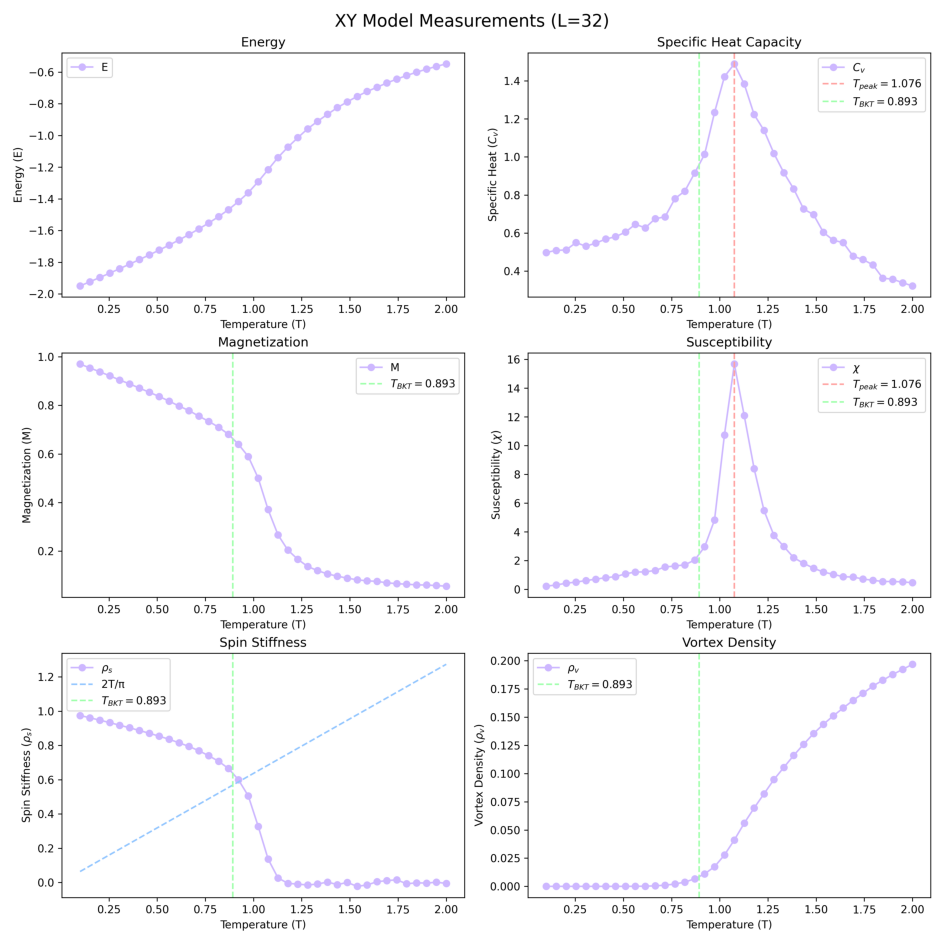

In [42]:
save_dir_root = Path(save_dir_root)
sampler_name = mc.XYModel.__name__
mc_data_dir = save_dir_root / "mc_data"
sampler_dir = mc_data_dir / sampler_name
field_config_dir = sampler_dir / "field_config"
filename_base = f"{sampler_name}_L{L}_T{T_start:.3f}-{T_end:.3f}_prec{precision:.3f}_ens{ensemble_number}"
filename_base = filename_base.replace('.', '_')
config_save_path = field_config_dir / f"{filename_base}_configs.pt"

mc_config_results = torch.load(config_save_path, map_location='cpu', weights_only=False)

measurement_dir = sampler_dir / "measurement"
measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

mc_measure_results = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

measurement_save_path_png = measurement_dir / f"{filename_base}_plots.png"
img = pf.load_image_pil(measurement_save_path_png)

pf.display_image_pil(img, figsize=(12, 12))

In [43]:
xy_spin_config = mc_config_results['configs']
labels = mc_config_results['labels']
T = torch.linspace(T_start, T_end, int((T_end - T_start) // precision) + 1, device=device)

xy_spin_config.shape

torch.Size([38, 2500, 32, 32])

In [44]:
trash.append(mc_config_results)
pf.clear_cuda_cache(trash)
trash = []

In [45]:
num_conditions = 1

unet_parameter_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'model_channels': 32,
    'downsample_out_ch_mult': (1, 1, 2,),
    'start_attn_level': 2,
    'num_blocks': 1,
    'dropout': 0.2,
    'num_heads': 4,
    'num_conditions': num_conditions,
    'emb_dim': 32,
    'padding_mode': 'circular',
}

unet = pfm.FlowUNet(**unet_parameter_dict).to(device)

dummy_inputs = {
    'x': torch.randn(32, 1, L, L, device="cuda"),
    'time': torch.randn(32, device="cuda"),
    'conditions': [torch.randn(32, device="cuda") for _ in range(num_conditions)]
}

pf.profile_model(unet, dummy_inputs)

Parameters:                           214.65 K
FLOPs (floating point operations):    0.9776 G
Estimated memory usage (params only): 0.82 MB


In [46]:
num_conditions = 1

dit_parameter_dict = {
    "patch_size": 2,
    "in_channels": 1,
    "hidden_dim": 128,
    "depth": 4,
    "num_heads": 8,
    "mlp_ratio": 4.0,
    "learn_sigma": False,
    "cond_freq_emb_size": 32,
    "time_freq_emb_size": 32,
    "rope_base": 10000,
    "max_rope_res_h": 64,
    "max_rope_res_w": 64,
}

dit = pfm.FlexibleDiT(**dit_parameter_dict).to(device)

dummy_inputs = {
    'x': torch.randn(32, 1, L, L, device="cuda"),
    'time': torch.randn(32, device="cuda"),
    'conditions': [torch.randn(32, device="cuda") for _ in range(num_conditions)],
}

pf.profile_model(dit, dummy_inputs)

Parameters:                           1262.98 K
FLOPs (floating point operations):    6.4847 G
Estimated memory usage (params only): 4.82 MB


In [47]:
t_focus_start_1 = 0.0
t_focus_end_1 = 1.38
t_focus_start_index_1 = len(T[T <= t_focus_start_1])
t_focus_end_index_1 = len(T[T <= t_focus_end_1])

In [48]:
labels_selected = labels[:, 0]

transform_1 = Compose([
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    RandomHorizontalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    RandomVerticalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
])

xy_dataset_raw = mc.MCDataset(
    data=xy_spin_config,
    labels=labels_selected,
)

xy_dataset_transform_1 = mc.MCDataset(
    data=xy_spin_config,
    labels=labels_selected,
    transform=transform_1,
)

xy_spin_config_focus = xy_spin_config[t_focus_start_index_1:t_focus_end_index_1, ...]
labels_selected_focus = labels_selected[t_focus_start_index_1:t_focus_end_index_1, ...]

reps = math.ceil(xy_spin_config.shape[0] / xy_spin_config_focus.shape[0])
repeated_config_focus = xy_spin_config_focus.repeat(reps,1,1,1)[:xy_spin_config.shape[0], ...]
repeated_labels_focus = labels_selected_focus.repeat(reps)[:xy_spin_config.shape[0], ...]

xy_dataset_focus_1_transform_1 = mc.MCDataset(
    data=repeated_config_focus,
    labels=repeated_labels_focus,
    transform=transform_1,
)

xy_dataset = ConcatDataset([
    xy_dataset_raw,
    xy_dataset_transform_1,
    xy_dataset_focus_1_transform_1
])

batch_size = 32
batch_size_mod = pf.find_closest_factor(len(xy_dataset), batch_size)
print(f"Optimal batch size: {batch_size_mod}")

xy_dataloader = DataLoader(xy_dataset, batch_size=batch_size_mod,shuffle=True)

Optimal batch size: 30


In [49]:
save_root = './'
save_folder_name = 'dit_vs_unet_log'
pf.create_directory(root_path=save_root, folder_name=save_folder_name)
save_dir_root = Path(save_root) / save_folder_name
unet_save_folder_name = 'unet'
dit_save_folder_name = 'dit'
pf.create_directory(root_path=save_dir_root, folder_name=unet_save_folder_name)
pf.create_directory(root_path=save_dir_root, folder_name=dit_save_folder_name)
unet_save_dir = save_dir_root / unet_save_folder_name
dit_save_dir = save_dir_root / dit_save_folder_name

In [50]:
gradient_accumulation_steps = 4
base_lr = gradient_accumulation_steps * 2e-4
total_epochs = 10

In [51]:
def random_global_rotate(x: torch.Tensor) -> torch.Tensor:
    """Apply a random global rotation (phase shift) to each 2-D field in a batch.

    The same random scalar θ ∈ [0, 2π) is added to **all** spatial positions
    in each sample.  After the shift, the result is wrapped into the range
    `[0, 2π)` with a modulo operation.

    Args:
        x (torch.Tensor): Input tensor of shape **(B, 1, H, W)** and any
            floating‐point dtype.

    Returns:
        torch.Tensor: Tensor with the same shape, dtype, and device as `x`,
        where for every *b* in `0 … B-1`

        ```text
        y[b, 0, :, :] = (x[b, 0, :, :] + θ_b) mod 2π.
        ```

    Notes:
        * The function is fully differentiable.
        * If `x` requires gradients, the returned tensor will as well.

    """
    if x.ndim != 4 or x.size(1) != 1:
        raise ValueError(
            f"Expected input of shape (B, 1, H, W); got {tuple(x.shape)}"
        )

    # Draw B independent scalars θ_b ∈ [0, 2π) with the same dtype/device as `x`.
    theta: torch.Tensor = torch.rand(
        x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device
    ) * (2 * torch.pi)

    # Add and wrap into [0, 2π).
    y: torch.Tensor = torch.fmod(x + theta, 2 * torch.pi)

    return (y - torch.pi) / torch.pi  # Shift to [-1, 1] range for better training stability.
    # return y

In [52]:
unet_optimizer = torch.optim.AdamW(unet.parameters(), lr=base_lr, weight_decay=0.1)
dit_optimizer = torch.optim.AdamW(dit.parameters(), lr=base_lr, weight_decay=0.1)

unet_scheduler = OneCycleLR(
    optimizer=unet_optimizer,
    max_lr=base_lr,
    total_steps=total_epochs+1,
    pct_start=1/3
)
dit_scheduler = OneCycleLR(
    optimizer=dit_optimizer,
    max_lr=base_lr,
    total_steps=total_epochs+1,
    pct_start=1/3
)

unet_fmex = pfm.CFMExecutor(
    save_dir_root=unet_save_dir,
    model_params=unet_parameter_dict,
    model=unet,
    model_wrapper=pfm.CFMWrapper,
    optimizer=unet_optimizer,
    lr_scheduler=unet_scheduler,
    device=device,
)
dit_fmex = pfm.CFMExecutor(
    save_dir_root=dit_save_dir,
    model_params=dit_parameter_dict,
    model=dit,
    model_wrapper=pfm.CFMWrapper,
    optimizer=dit_optimizer,
    lr_scheduler=dit_scheduler,
    device=device,
)

2025-07-19 18:18:19,787 - INFO - Save directory root 'dit_vs_unet_log/unet' confirmed/created.
2025-07-19 18:18:19,789 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-07-19 18:18:19,790 - INFO - CFMExecutor initialized. Device: cuda:0
2025-07-19 18:18:19,790 - INFO - Save directory root: dit_vs_unet_log/unet
2025-07-19 18:18:19,791 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be available if data shape is incompatible.
2025-07-19 18:18:19,795 - INFO - Save directory root 'dit_vs_unet_log/dit' confirmed/created.
2025-07-19 18:18:19,797 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-07-19 18:18:19,797 - INFO - CFMExecutor initialized. Device: cuda:0
2025-07-19 18:18:19,798 - INFO - Save directory root: dit_vs_unet_log/dit
2025-07-19 18:18:19,799 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be availab

In [18]:
unet_fmex.train(
    train_loaders=(
        xy_dataloader,
    ),
    num_epochs=total_epochs,
    save_every_epochs=10,
    gradient_accumulation_steps=gradient_accumulation_steps,
    mu_logit=0.0,
    sigma_logit = 1.0,
    data_argumentation_fn=random_global_rotate
)

2025-07-19 16:14:09,689 - INFO - Total batches per epoch from all loaders: 9500
2025-07-19 16:14:09,690 - INFO - Effective batch size (approx, based on first loader): 120
2025-07-19 16:14:09,691 - INFO - Starting training for 10 epochs.
2025-07-19 16:14:09,691 - INFO - Gradient Accumulation Steps: 4
2025-07-19 16:14:09,692 - INFO - Using logit-normal sampler with mu_logit=0.0000, sigma_logit=1.0000. This controls the sampling distribution for time t.
2025-07-19 16:16:21,112 - INFO - Epoch 1/10 completed in 131.42s.                                          
2025-07-19 16:16:21,112 - INFO -   Average Epoch Loss: 0.8908
2025-07-19 16:16:21,113 - INFO -   Optimizer steps in epoch: 2375
2025-07-19 16:16:21,113 - INFO -   Last AutoClip threshold used: 0.1859
2025-07-19 16:16:21,114 - INFO -   LR scheduler stepped. New LR: 0.000269
2025-07-19 16:16:21,114 - INFO - ------------------------------------------------------------
2025-07-19 16:16:21,115 - INFO - Keeping sigma_logit = 1.0000 for thi

In [19]:
dit_fmex.train(
    train_loaders=(
        xy_dataloader,
    ),
    num_epochs=total_epochs,
    save_every_epochs=10,
    gradient_accumulation_steps=gradient_accumulation_steps,
    mu_logit=0.0,
    sigma_logit = 1.0,
    data_argumentation_fn=random_global_rotate
)

2025-07-19 16:35:03,002 - INFO - Total batches per epoch from all loaders: 9500
2025-07-19 16:35:03,002 - INFO - Effective batch size (approx, based on first loader): 120
2025-07-19 16:35:03,003 - INFO - Starting training for 10 epochs.
2025-07-19 16:35:03,003 - INFO - Gradient Accumulation Steps: 4
2025-07-19 16:35:03,004 - INFO - Using logit-normal sampler with mu_logit=0.0000, sigma_logit=1.0000. This controls the sampling distribution for time t.
2025-07-19 16:36:57,144 - INFO - Epoch 1/10 completed in 114.14s.                                          
2025-07-19 16:36:57,144 - INFO -   Average Epoch Loss: 0.6934
2025-07-19 16:36:57,145 - INFO -   Optimizer steps in epoch: 2375
2025-07-19 16:36:57,145 - INFO -   Last AutoClip threshold used: 1.1185
2025-07-19 16:36:57,146 - INFO -   LR scheduler stepped. New LR: 0.000269
2025-07-19 16:36:57,146 - INFO - ------------------------------------------------------------
2025-07-19 16:36:57,146 - INFO - Keeping sigma_logit = 1.0000 for thi

In [53]:
unet_fmex.load_checkpoint(unet_save_dir/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

L = 32
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = unet,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = unet_fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
)

sol_unet = unet_fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
torch.cuda.empty_cache()

2025-07-19 18:18:31,903 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-07-19 18:18:31,904 - INFO - Loaded checkpoint from dit_vs_unet_log/unet/checkpoints/checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-07-19 18:18:31,904 - INFO - Training will resume from epoch 11.
2025-07-19 18:18:31,905 - INFO -   Last recorded average epoch loss: 0.5426
2025-07-19 18:18:31,905 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'downsample_out_ch_mult': (1, 1, 2), 'start_attn_level': 2, 'num_blocks': 1, 'dropout': 0.2, 'num_heads': 4, 'num_conditions': 1, 'emb_dim': 32, 'padding_mode': 'circular'}


num_temp: 190
Optimal batch size: 630
Optimal batch size (modify): 625


2025-07-19 18:18:32,917 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-07-19 18:18:32,918 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-07-19 18:18:32,918 - INFO - Starting sample generation (solving ODE)...
2025-07-19 18:18:32,919 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-07-19 18:18:32,921 - INFO -   Time Grid (Fixed Steps): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-07-19 18:18:32,922 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-07-19 18:18:33,782 - INFO - GPU warmup completed. Returning empty tensor.
2025-07-19 18:18:33,788 - INFO - Using the original model's velocity field (via wrapper) 

In [54]:
dit_fmex.load_checkpoint(dit_save_dir/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

L = 32
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = dit,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = dit_fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
)
sol_dit = dit_fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
torch.cuda.empty_cache()

2025-07-19 18:19:23,463 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-07-19 18:19:23,463 - INFO - Loaded checkpoint from dit_vs_unet_log/dit/checkpoints/checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-07-19 18:19:23,464 - INFO - Training will resume from epoch 11.
2025-07-19 18:19:23,464 - INFO -   Last recorded average epoch loss: 0.5473
2025-07-19 18:19:23,465 - INFO -   Associated model params from checkpoint: {'patch_size': 2, 'in_channels': 1, 'hidden_dim': 128, 'depth': 4, 'num_heads': 8, 'mlp_ratio': 4.0, 'learn_sigma': False, 'cond_freq_emb_size': 32, 'time_freq_emb_size': 32, 'rope_base': 10000, 'max_rope_res_h': 64, 'max_rope_res_w': 64}


num_temp: 190
Optimal batch size: 223
Optimal batch size (modify): 200


2025-07-19 18:19:24,438 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-07-19 18:19:24,438 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-07-19 18:19:24,439 - INFO - Starting sample generation (solving ODE)...
2025-07-19 18:19:24,439 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-07-19 18:19:24,440 - INFO -   Time Grid (Fixed Steps): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-07-19 18:19:24,441 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-07-19 18:19:25,325 - INFO - GPU warmup completed. Returning empty tensor.
2025-07-19 18:19:25,346 - INFO - Using the original model's velocity field (via wrapper) 

In [55]:
unet_sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)
dit_sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

unet_sampler_xy.spins = sol_unet * torch.pi + torch.pi  # Shift to [0, 2π) range for sampling.
dit_sampler_xy.spins = sol_dit * torch.pi + torch.pi  # Shift to [0, 2π) range for sampling.
trash.append(sol_unet)
trash.append(sol_dit)
pf.clear_cuda_cache(trash)
trash = []

Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


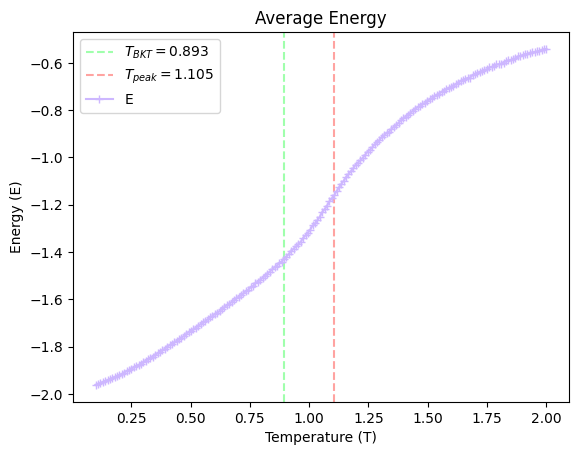

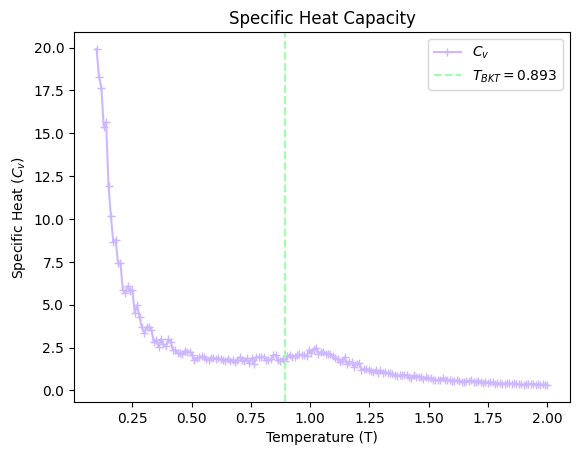

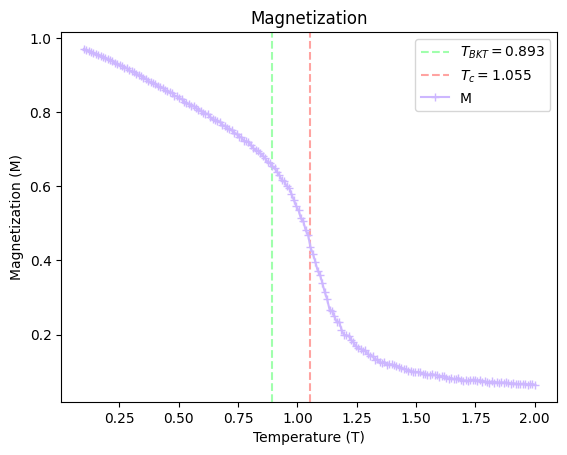

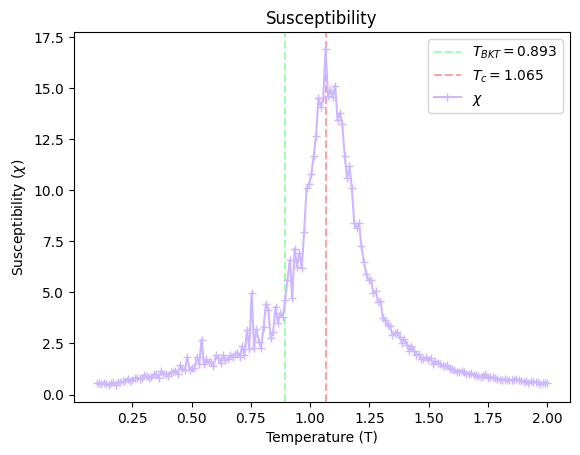

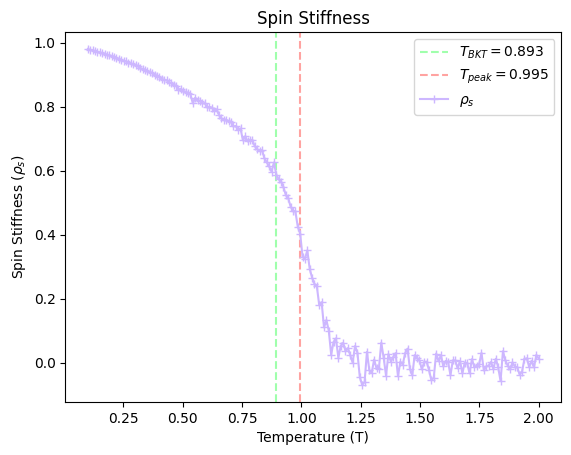

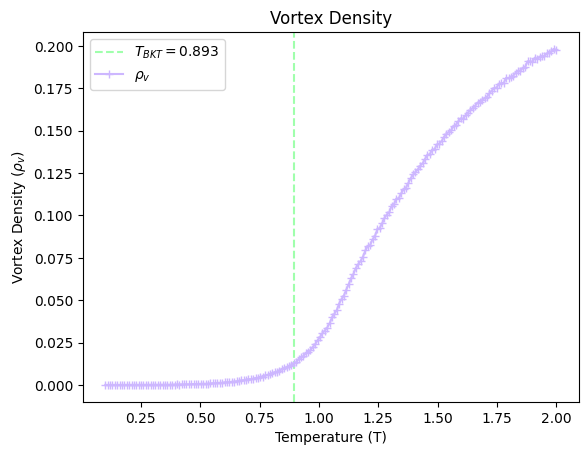

In [56]:
fm_energy_unet = unet_sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_specific_heat_unet = unet_sampler_xy.plot_specific_heat(
    plot_t_bkt=True,
    plot_peak_line=False,
    return_observation=True
)
fm_magnetization_unet = unet_sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_unet = unet_sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_unet = unet_sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_unet = unet_sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

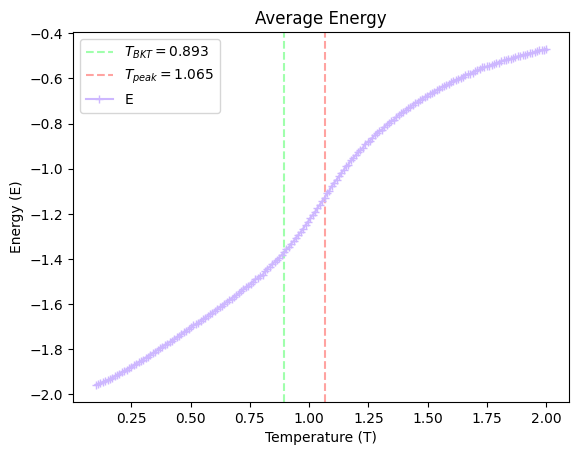

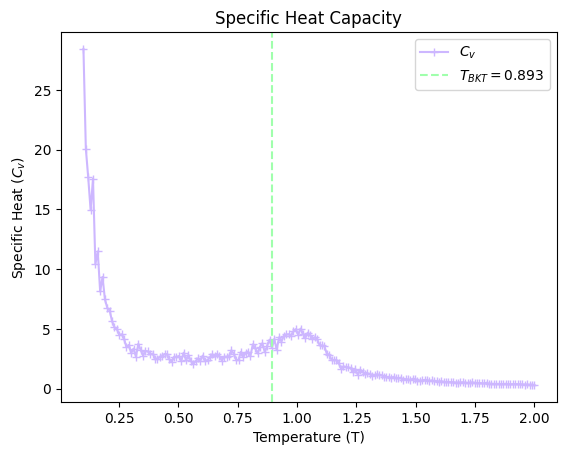

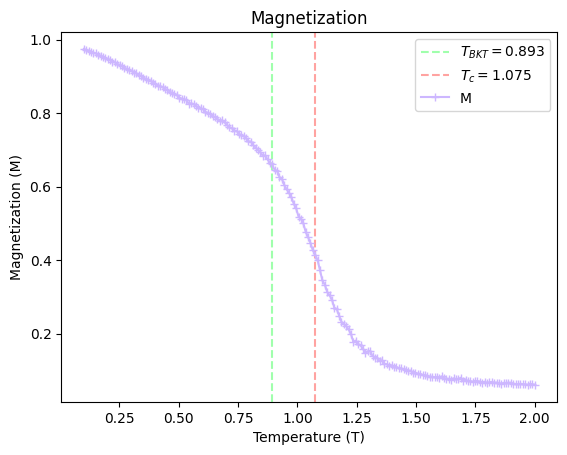

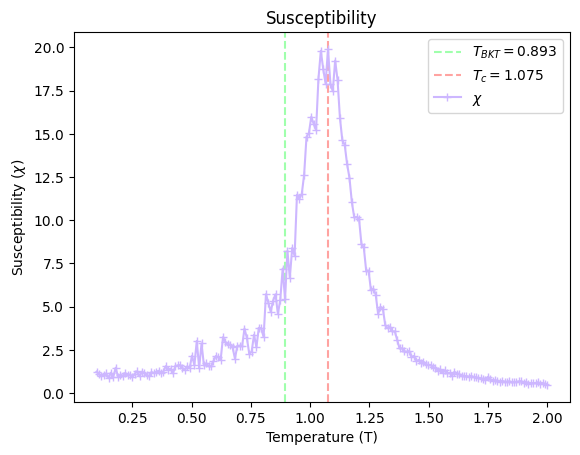

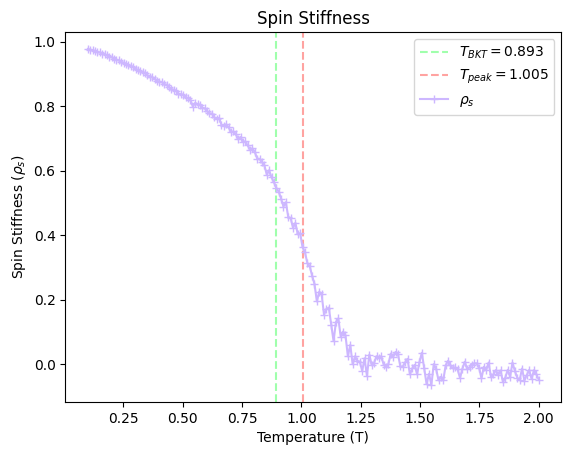

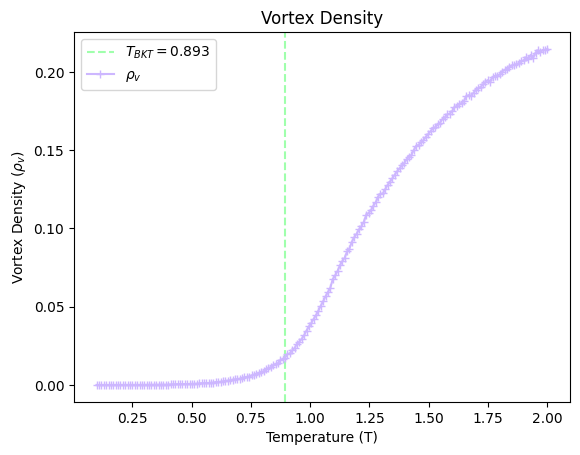

In [57]:
fm_energy_dit = dit_sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_specific_heat_dit = dit_sampler_xy.plot_specific_heat(
    plot_t_bkt=True,
    plot_peak_line=False,
    return_observation=True
)
fm_magnetization_dit = dit_sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_dit = dit_sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_dit = dit_sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_dit = dit_sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [58]:
mc_temperature = mc_measure_results['temperature']
mc_energy = mc_measure_results['energy']
mc_specific_heat = mc_measure_results['specific_heat']
mc_magnetization = mc_measure_results['magnetization']
mc_susceptibility = mc_measure_results['susceptibility']
mc_stiffness = mc_measure_results['spin_stiffness']
mc_vortex_density = mc_measure_results['vortex_density']

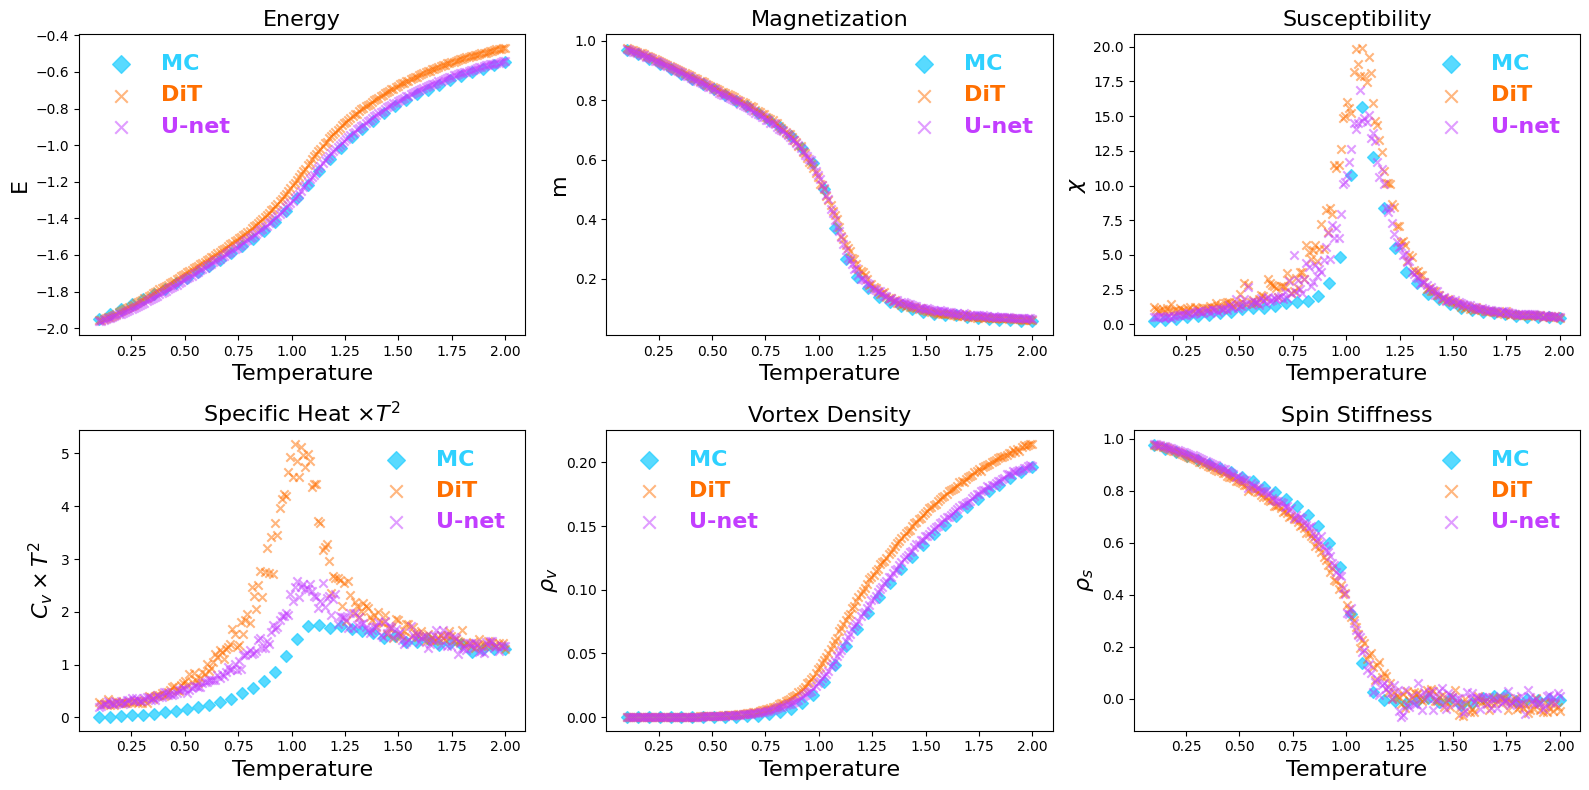

In [59]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
unet_fm_color = '#C23DFF'
dit_fm_color = '#FF6F00'

fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax[0, 0].scatter(mc_temperature, mc_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0, 0].scatter(Temp.cpu(), fm_energy_dit, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[0, 0].scatter(Temp.cpu(), fm_energy_unet, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[0, 0].set_ylabel('E', fontsize=16)
ax[0, 0].set_title('Energy', fontsize=16)

ax[0, 1].scatter(mc_temperature, mc_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0, 1].scatter(Temp.cpu(), fm_magnetization_dit, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[0, 1].scatter(Temp.cpu(), fm_magnetization_unet, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[0, 1].set_ylabel('m', fontsize=16)
ax[0, 1].set_title('Magnetization', fontsize=16)

ax[0, 2].scatter(mc_temperature, mc_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0, 2].scatter(Temp.cpu(), fm_susceptibility_dit, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[0, 2].scatter(Temp.cpu(), fm_susceptibility_unet, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[0, 2].set_ylabel(r'$\chi$', fontsize=16)
ax[0, 2].set_title('Susceptibility', fontsize=16)

ax[1, 0].scatter(mc_temperature, mc_specific_heat * mc_temperature**2, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1, 0].scatter(Temp.cpu(), fm_specific_heat_dit * Temp.cpu().numpy()**2, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[1, 0].scatter(Temp.cpu(), fm_specific_heat_unet * Temp.cpu().numpy()**2, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[1, 0].set_ylabel('$C_v\\times T^2$', fontsize=16)
ax[1, 0].set_title('Specific Heat $\\times T^2$', fontsize=16)

ax[1, 1].scatter(mc_temperature, mc_vortex_density, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1, 1].scatter(Temp.cpu(), fm_vortex_density_dit, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[1, 1].scatter(Temp.cpu(), fm_vortex_density_unet, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[1, 1].set_ylabel(r'$\rho_v$', fontsize=16)
ax[1, 1].set_title('Vortex Density', fontsize=16)

ax[1, 2].scatter(mc_temperature, mc_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1, 2].scatter(Temp.cpu(), fm_stiffness_dit, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[1, 2].scatter(Temp.cpu(), fm_stiffness_unet, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[1, 2].set_ylabel(r'$\rho_s$', fontsize=16)
ax[1, 2].set_title('Spin Stiffness', fontsize=16)

for i in range(2):
    for j in range(3):
        ax[i, j].set_xlabel('Temperature', fontsize=16)
        ax[i, j].legend(
            prop={'weight': 'bold', 'size': 16},
            labelcolor=[
                mc_color,
                dit_fm_color,
                unet_fm_color
            ],
            markerscale=1.5,
            frameon=False
        )
plt.tight_layout()
plt.show()

In [60]:
def mse_mae_estimator(fm_data_list, mc_data_list):
    """
    Calculate the MSE and MAE between flow matching and Monte Carlo data.

    Args:
        fm_data_list (list): List of flow matching data tensors.
        mc_data_list (list): List of Monte Carlo data tensors.

    Returns:
        tuple: MSE and MAE values.
    """
    mse_list = []
    mae_list = []

    for fm_data, mc_data in zip(fm_data_list, mc_data_list):
        fm_tensor = torch.tensor(fm_data[::5])  # Reduce by factor of 5
        mc_tensor = torch.tensor(mc_data)

        mse = torch.nn.functional.mse_loss(fm_tensor, mc_tensor)
        mae = torch.nn.functional.l1_loss(fm_tensor, mc_tensor)

        mse_list.append(mse.item())
        mae_list.append(mae.item())

    return mse_list, mae_list

In [61]:
fm_unet_results_list = [
    fm_energy_unet,
    fm_magnetization_unet,
    fm_susceptibility_unet,
    fm_stiffness_unet,
    fm_vortex_density_unet,
    fm_specific_heat_unet
]
fm_dit_results_list = [
    fm_energy_dit,
    fm_magnetization_dit,
    fm_susceptibility_dit,
    fm_stiffness_dit,
    fm_vortex_density_dit,
    fm_specific_heat_dit
]
mc_results_list = [
    mc_energy,
    mc_magnetization,
    mc_susceptibility,
    mc_stiffness,
    mc_vortex_density,
    mc_specific_heat
]

unet_mse_list, unet_mae_list = mse_mae_estimator(fm_unet_results_list, mc_results_list)
dit_mse_list, dit_mae_list = mse_mae_estimator(fm_dit_results_list, mc_results_list)

print(f"U-net Average MSE: {sum(unet_mse_list) / len(unet_mae_list)} ")
print(f"U-net Average MAE: {sum(unet_mae_list) / len(unet_mae_list)} ")
print(f"DiT Average MSE: {sum(dit_mse_list) / len(dit_mae_list)} ")
print(f"DiT Average MAE: {sum(dit_mae_list) / len(dit_mae_list)} ")

U-net Average MSE: 3.0007004366203014 
U-net Average MAE: 0.449584221021117 
DiT Average MSE: 5.587909771752796 
DiT Average MAE: 0.6908687083050609 


# Large Scale Inference

## Generate MC XY Configurations for comparison

In [64]:
save_dir_root = './'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L = 64
T_start = 0.1
T_end = 2.0
precision = 0.01
ensemble_number = 1500

2025-07-19 18:22:55,582 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [65]:
xy_generator.forward(
    L=L,
    T_start=T_start,
    T_end=T_end,
    precision=precision,
    ensemble_number=ensemble_number,
    device=device,
)
trash.append(xy_generator)

2025-07-19 18:22:55,701 - INFO - --- Simulation Parameters for XYModel ---
2025-07-19 18:22:55,702 - INFO - Lattice size (L): 64
2025-07-19 18:22:55,702 - INFO - Temperature range: 0.1 to 2.0 (precision: 0.01, steps: 190)
2025-07-19 18:22:55,702 - INFO - Device: cuda:0
2025-07-19 18:22:55,703 - INFO - Ensemble number per T: 1500
2025-07-19 18:22:55,703 - INFO - Number of chains (n_chains): 10
2025-07-19 18:22:55,704 - INFO - Parallel Tempering: Enabled (interval: 1, prob: 0.1)
2025-07-19 18:22:55,705 - INFO - Calculated tau: 9410.1, tau_eff: 10.0
2025-07-19 18:22:55,705 - INFO - Thermalization sweeps (n_therm): 282304 (factor: 30)
2025-07-19 18:22:55,705 - INFO - Decorrelation sweeps (decorrelate): 19 (factor: 2)
2025-07-19 18:22:55,706 - INFO - Production sweeps (n_sweeps): 2850
2025-07-19 18:22:55,706 - INFO - -----------------------------------------------------
2025-07-19 18:22:55,710 - INFO - Starting Monte Carlo simulation...


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=190, ChainsPerTemp=10, AMP=True, PT=True, LargeSim=False
Starting simulation: 282304 thermalization sweeps, 2850 production sweeps.
Thermalization phase...
Production phase...
Simulation finished. Collected 1500 samples.


2025-07-19 19:10:03,581 - INFO - Simulation finished. Elapsed time: 2827.87 s
2025-07-19 19:10:03,581 - INFO - Generated samples shape: torch.Size([190, 1500, 64, 64])
2025-07-19 19:10:03,583 - INFO - Ensured directory exists: mc_data
2025-07-19 19:10:03,585 - INFO - Ensured directory exists: mc_data/XYModel
2025-07-19 19:10:03,588 - INFO - Ensured directory exists: mc_data/XYModel/field_config
2025-07-19 19:10:03,590 - INFO - Ensured directory exists: mc_data/XYModel/measurement
2025-07-19 19:10:03,591 - INFO - Saving field configurations to: mc_data/XYModel/field_config/XYModel_L64_T0_100-2_000_prec0_010_ens1500_configs.pt
2025-07-19 19:10:03,591 - INFO - Configs tensor shape: torch.Size([190, 1500, 64, 64])
2025-07-19 19:10:03,592 - INFO - Labels tensor shape: torch.Size([190, 2])


labels shape: torch.Size([190, 2])
first label pair: tensor([ 0.1000, 64.0000])


2025-07-19 19:10:26,631 - INFO - Field configurations saved.
2025-07-19 19:10:26,632 - INFO - Performing measurements...
2025-07-19 19:10:36,709 - INFO - Measurements complete.
2025-07-19 19:10:36,709 - INFO - Saving measurements dictionary to: mc_data/XYModel/measurement/XYModel_L64_T0_100-2_000_prec0_010_ens1500_measurements.pt
2025-07-19 19:10:36,713 - INFO - Measurements dictionary saved.
2025-07-19 19:10:36,713 - INFO - Saving plots to: mc_data/XYModel/measurement/XYModel_L64_T0_100-2_000_prec0_010_ens1500_plots.png
2025-07-19 19:10:37,206 - INFO - Plots saved.
2025-07-19 19:10:37,827 - INFO - Cleared CUDA cache.
2025-07-19 19:10:37,827 - INFO - MCDataGenerator call finished. Total time: 2862.13 s


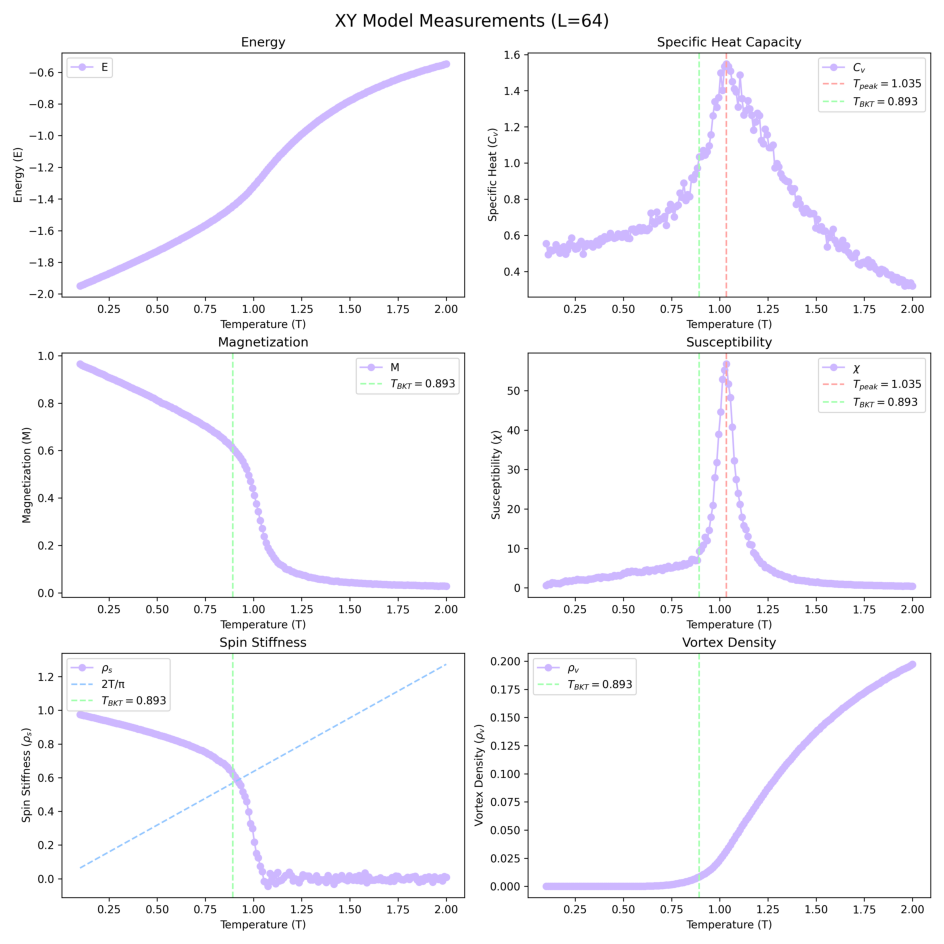

In [66]:
save_dir_root = Path(save_dir_root)
sampler_name = mc.XYModel.__name__
mc_data_dir = save_dir_root / "mc_data"
sampler_dir = mc_data_dir / sampler_name
filename_base = f"{sampler_name}_L{L}_T{T_start:.3f}-{T_end:.3f}_prec{precision:.3f}_ens{ensemble_number}"
filename_base = filename_base.replace('.', '_')

measurement_dir = sampler_dir / "measurement"
measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

mc_measure_results_big = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

measurement_save_path_png = measurement_dir / f"{filename_base}_plots.png"
img = pf.load_image_pil(measurement_save_path_png)

pf.display_image_pil(img, figsize=(12, 12))

## Sample with U-net and DiT

### U-net

In [67]:
unet_fmex.load_checkpoint(unet_save_dir/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

L = 64
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = unet,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = unet_fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
)
sol_unet_big = unet_fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
torch.cuda.empty_cache()

2025-07-19 19:10:38,499 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-07-19 19:10:38,500 - INFO - Loaded checkpoint from dit_vs_unet_log/unet/checkpoints/checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-07-19 19:10:38,500 - INFO - Training will resume from epoch 11.
2025-07-19 19:10:38,501 - INFO -   Last recorded average epoch loss: 0.5426
2025-07-19 19:10:38,501 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'downsample_out_ch_mult': (1, 1, 2), 'start_attn_level': 2, 'num_blocks': 1, 'dropout': 0.2, 'num_heads': 4, 'num_conditions': 1, 'emb_dim': 32, 'padding_mode': 'circular'}


num_temp: 190
Optimal batch size: 159
Optimal batch size (modify): 152


2025-07-19 19:10:40,753 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-07-19 19:10:40,754 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-07-19 19:10:40,754 - INFO - Starting sample generation (solving ODE)...
2025-07-19 19:10:40,755 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-07-19 19:10:40,756 - INFO -   Time Grid (Fixed Steps): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-07-19 19:10:40,757 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-07-19 19:10:41,590 - INFO - GPU warmup completed. Returning empty tensor.
2025-07-19 19:10:41,596 - INFO - Using the original model's velocity field (via wrapper) 

### DiT

In [68]:
dit_fmex.load_checkpoint(dit_save_dir/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

L = 64
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = dit,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = dit_fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
)
sol_dit_big = dit_fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
torch.cuda.empty_cache()

2025-07-19 19:14:05,076 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-07-19 19:14:05,077 - INFO - Loaded checkpoint from dit_vs_unet_log/dit/checkpoints/checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-07-19 19:14:05,077 - INFO - Training will resume from epoch 11.
2025-07-19 19:14:05,078 - INFO -   Last recorded average epoch loss: 0.5473
2025-07-19 19:14:05,078 - INFO -   Associated model params from checkpoint: {'patch_size': 2, 'in_channels': 1, 'hidden_dim': 128, 'depth': 4, 'num_heads': 8, 'mlp_ratio': 4.0, 'learn_sigma': False, 'cond_freq_emb_size': 32, 'time_freq_emb_size': 32, 'rope_base': 10000, 'max_rope_res_h': 64, 'max_rope_res_w': 64}


num_temp: 190
Optimal batch size: 26
Optimal batch size (modify): 25


2025-07-19 19:14:06,821 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-07-19 19:14:06,822 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-07-19 19:14:06,823 - INFO - Starting sample generation (solving ODE)...
2025-07-19 19:14:06,823 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-07-19 19:14:06,824 - INFO -   Time Grid (Fixed Steps): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-07-19 19:14:06,825 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-07-19 19:14:08,285 - INFO - GPU warmup completed. Returning empty tensor.
2025-07-19 19:14:08,298 - INFO - Using the original model's velocity field (via wrapper) 

In [69]:
unet_sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)
dit_sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

unet_sampler_xy.spins = sol_unet_big * torch.pi + torch.pi  # Shift to [0, 2π) range for sampling.
dit_sampler_xy.spins = sol_dit_big * torch.pi + torch.pi  # Shift to [0, 2π) range for sampling.
trash.append(sol_unet_big)
trash.append(sol_dit_big)
pf.clear_cuda_cache(trash)
trash = []

Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


### U-net Flow Matching Results

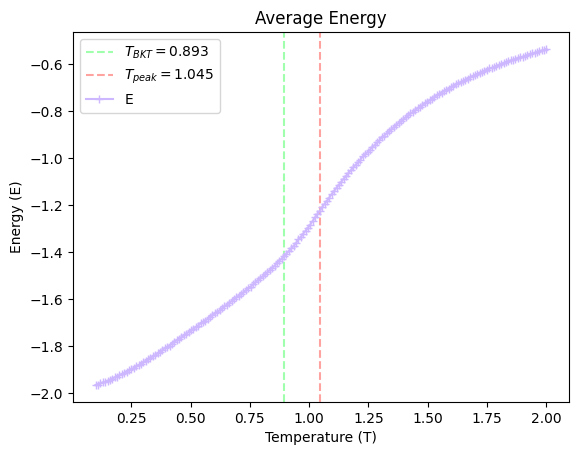

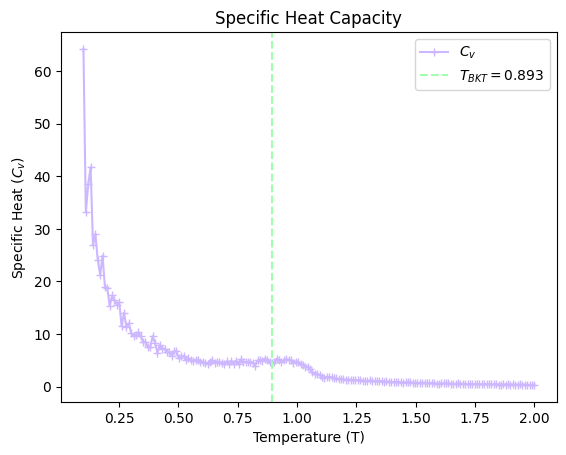

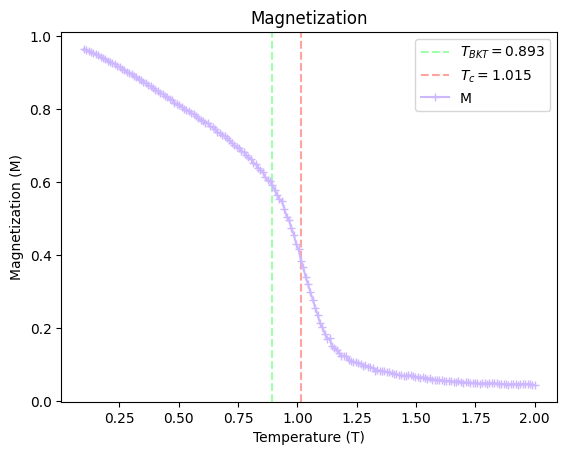

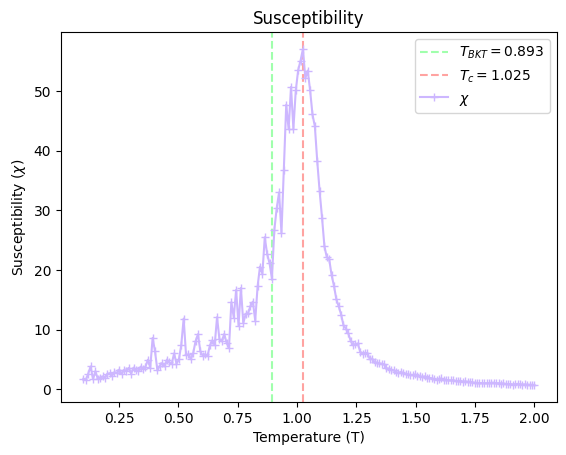

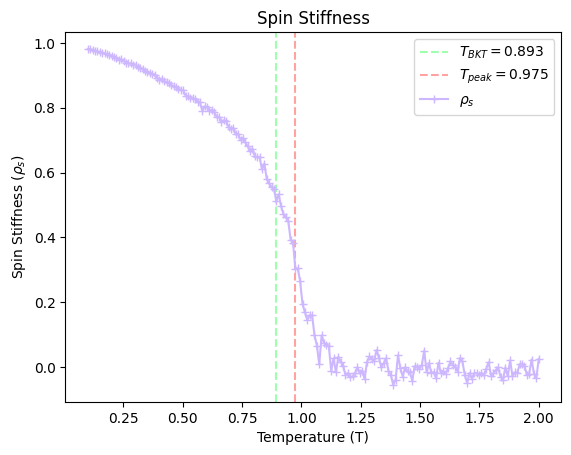

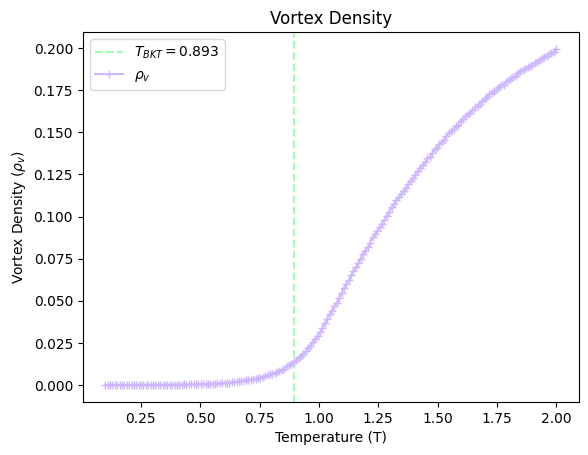

In [70]:
fm_energy_unet_big = unet_sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_specific_heat_unet_big = unet_sampler_xy.plot_specific_heat(
    plot_t_bkt=True,
    plot_peak_line=False,
    return_observation=True
)
fm_magnetization_unet_big = unet_sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_unet_big = unet_sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_unet_big = unet_sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_unet_big = unet_sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

### DiT Flow Matching Results

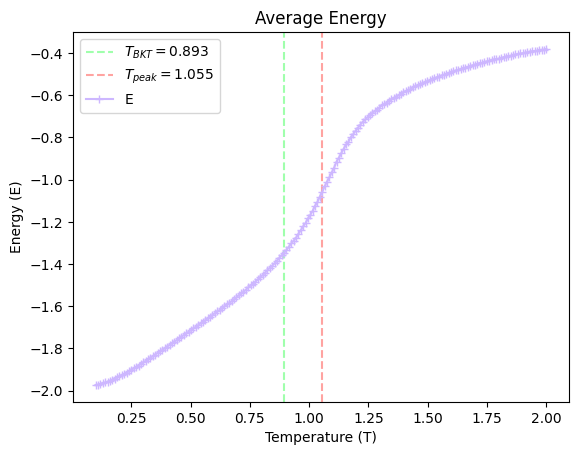

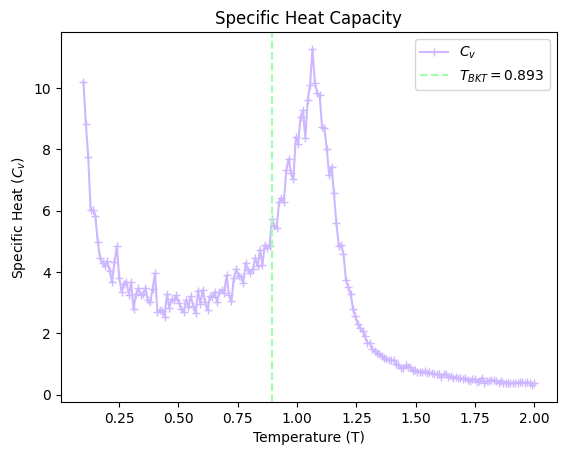

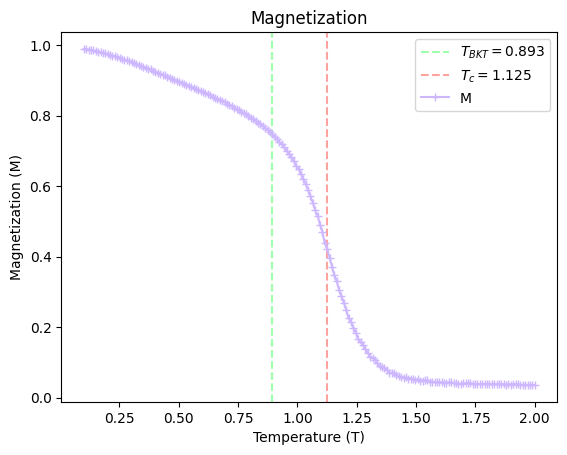

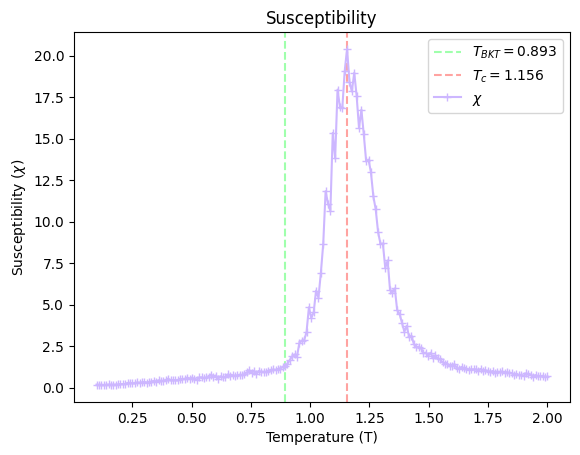

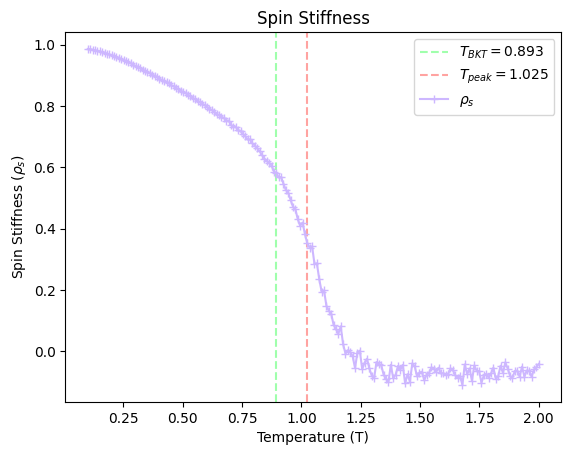

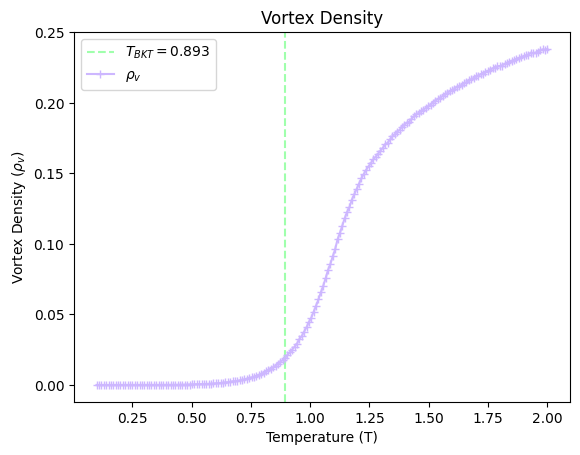

In [71]:
fm_energy_dit_big = dit_sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_specific_heat_dit_big = dit_sampler_xy.plot_specific_heat(
    plot_t_bkt=True,
    plot_peak_line=False,
    return_observation=True
)
fm_magnetization_dit_big = dit_sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_dit_big = dit_sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_dit_big = dit_sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_dit_big = dit_sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [72]:
mc_temperature_big = mc_measure_results_big['temperature']
mc_energy_big = mc_measure_results_big['energy']
mc_specific_heat_big = mc_measure_results_big['specific_heat']
mc_magnetization_big = mc_measure_results_big['magnetization']
mc_susceptibility_big = mc_measure_results_big['susceptibility']
mc_stiffness_big = mc_measure_results_big['spin_stiffness']
mc_vortex_density_big = mc_measure_results_big['vortex_density']

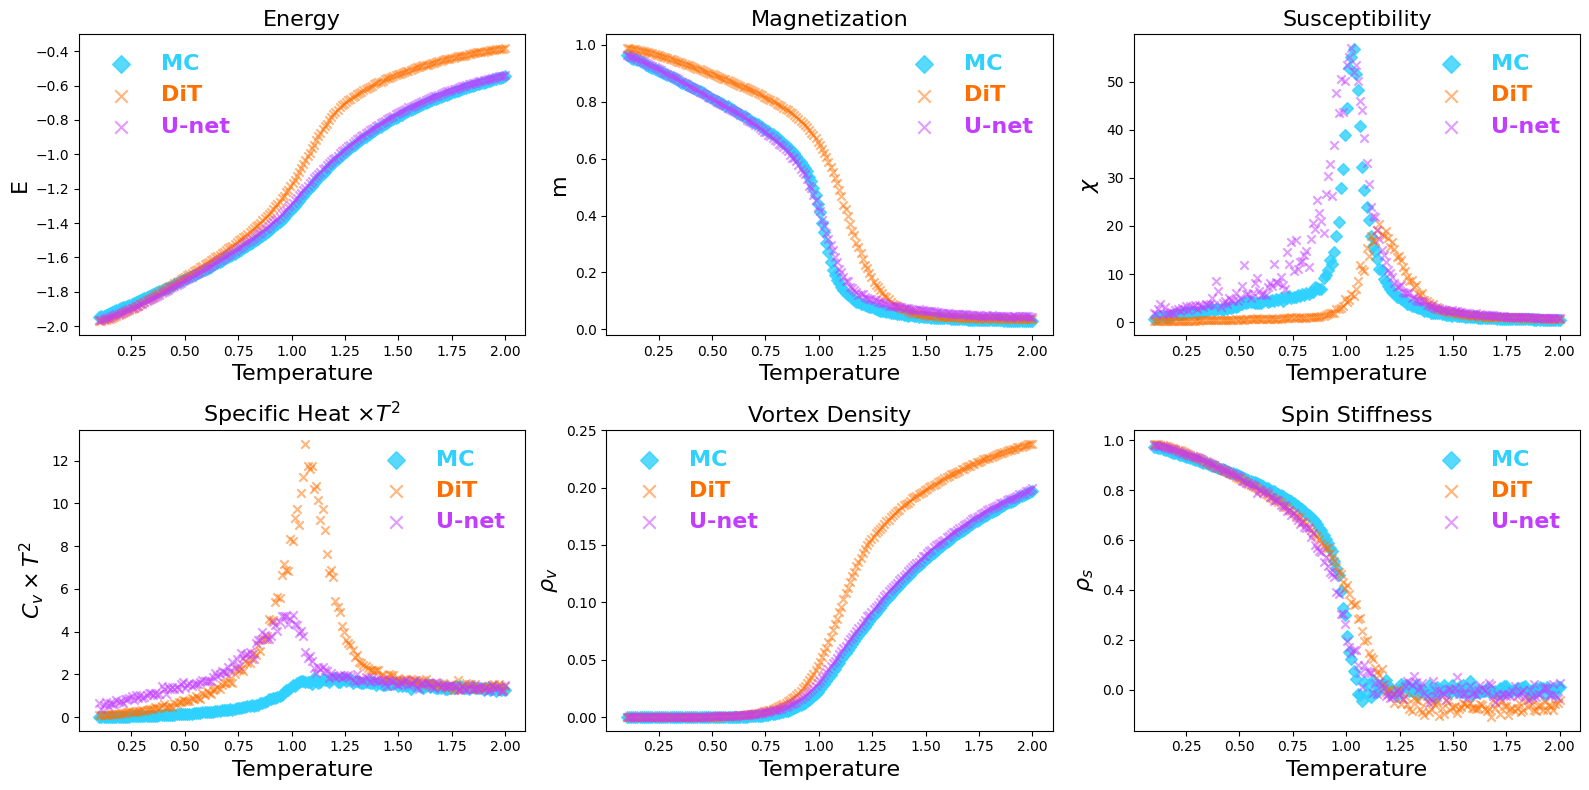

In [74]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
unet_fm_color = '#C23DFF'
dit_fm_color = '#FF6F00'

fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax[0, 0].scatter(mc_temperature_big, mc_energy_big, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0, 0].scatter(Temp.cpu(), fm_energy_dit_big, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[0, 0].scatter(Temp.cpu(), fm_energy_unet_big, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[0, 0].set_ylabel('E', fontsize=16)
ax[0, 0].set_title('Energy', fontsize=16)

ax[0, 1].scatter(mc_temperature_big, mc_magnetization_big, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0, 1].scatter(Temp.cpu(), fm_magnetization_dit_big, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[0, 1].scatter(Temp.cpu(), fm_magnetization_unet_big, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[0, 1].set_ylabel('m', fontsize=16)
ax[0, 1].set_title('Magnetization', fontsize=16)

ax[0, 2].scatter(mc_temperature_big, mc_susceptibility_big, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0, 2].scatter(Temp.cpu(), fm_susceptibility_dit_big, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[0, 2].scatter(Temp.cpu(), fm_susceptibility_unet_big, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[0, 2].set_ylabel(r'$\chi$', fontsize=16)
ax[0, 2].set_title('Susceptibility', fontsize=16)

ax[1, 0].scatter(mc_temperature_big, mc_specific_heat_big * mc_temperature_big**2, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1, 0].scatter(Temp.cpu(), fm_specific_heat_dit_big * Temp.cpu().numpy()**2, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[1, 0].scatter(Temp.cpu(), fm_specific_heat_unet_big * Temp.cpu().numpy()**2, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[1, 0].set_ylabel('$C_v\\times T^2$', fontsize=16)
ax[1, 0].set_title('Specific Heat $\\times T^2$', fontsize=16)

ax[1, 1].scatter(mc_temperature_big, mc_vortex_density_big, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1, 1].scatter(Temp.cpu(), fm_vortex_density_dit_big, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[1, 1].scatter(Temp.cpu(), fm_vortex_density_unet_big, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[1, 1].set_ylabel(r'$\rho_v$', fontsize=16)
ax[1, 1].set_title('Vortex Density', fontsize=16)

ax[1, 2].scatter(mc_temperature_big, mc_stiffness_big, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1, 2].scatter(Temp.cpu(), fm_stiffness_dit_big, marker='x', label='DiT', color=dit_fm_color, alpha=0.5)
ax[1, 2].scatter(Temp.cpu(), fm_stiffness_unet_big, marker='x', label='U-net', color=unet_fm_color, alpha=0.5)
ax[1, 2].set_ylabel(r'$\rho_s$', fontsize=16)
ax[1, 2].set_title('Spin Stiffness', fontsize=16)

for i in range(2):
    for j in range(3):
        ax[i, j].set_xlabel('Temperature', fontsize=16)
        ax[i, j].legend(
            prop={'weight': 'bold', 'size': 16},
            labelcolor=[
                mc_color,
                dit_fm_color,
                unet_fm_color
            ],
            markerscale=1.5,
            frameon=False
        )
plt.tight_layout()
plt.show()